In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from mygrad.engine import Value
from mygrad.nn import *

## Function to produce network graphs

In [3]:
from graphviz import Digraph

def trace(root):
    '''
    Builds a set of all nodes and edges in the graph.
    '''
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir':'LR'})
    
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = '{ %s | data %.4f | grad %.4f}' % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name= uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
            
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot
                  
                

## Try on a custom expression

In [87]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.8813735870195432, label='b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o';

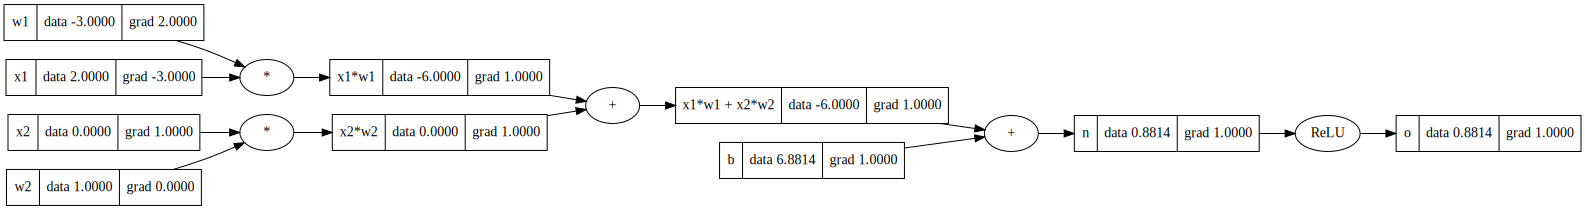

In [308]:
o.backward()
draw_dot(o)

## Try on a Neuron

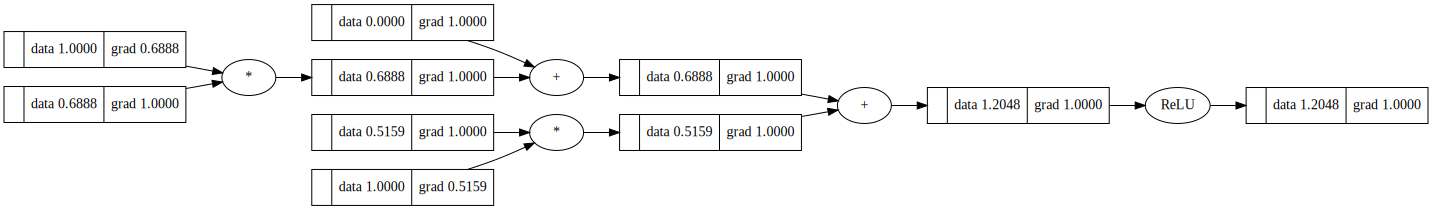

In [4]:
model = Neuron(2)
output = model([1,1])
output.backward()
draw_dot(output)

## Generate Dataset

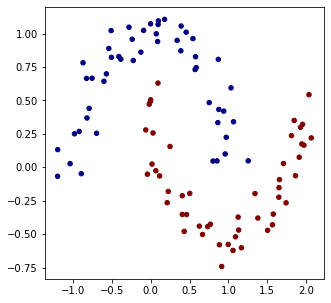

In [6]:
from sklearn.datasets import make_moons, make_blobs


X, y = make_moons(n_samples=100, noise=0.1)
# y[y==0] = -1

X_value = [[Value(x[0]), Value(x[1])] for x in X]
y_value = [Value(x) for x in y]


plt.figure(figsize=(5, 5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

## Initialize Multi-Layer Perceptron Model

In [82]:
model = MLP(2, [8, 8, 1])

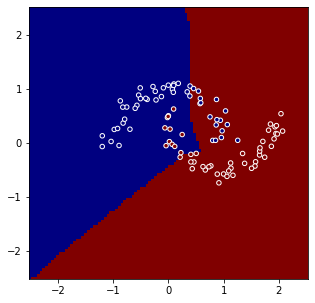

In [83]:
xx, yy = np.meshgrid(np.linspace(-2.5, 2.5, 100),
                     np.linspace(-2.5, 2.5, 100))
grid = [[a, b] for a, b in zip(xx.flatten(), yy.flatten())]

grid_activations = [model(x).data>0.5 for x in grid]
grid_activations = np.reshape(grid_activations, (100, 100))

plt.figure(figsize=(5, 5))
plt.pcolor(xx, yy, grid_activations, shading='auto', cmap='jet')
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet', edgecolor='w')

## Train with Gradient Descent and Mean Square + L2 Regularization Error

In [84]:
from IPython.display import clear_output

epochs = 200

losses = []
accuracies = []
alpha = Value(1e-4)


for epoch in range(1, epochs):
    
    lr = 0.01 #* (1 - epoch/epochs)
    
    # forward
    model.zero_grad()
    scores = list(map(model, X_value))
    data_loss = sum([(yp - ygt)**2 for yp, ygt in zip(scores,y_value)])/len(scores)


#     L2 regularization
    reg_loss = alpha * sum((p*p for p in model.parameters()))

    total_loss = data_loss + reg_loss

    acc = [y_i.data == round(score_i.data) for y_i, score_i in zip(y_value, scores)]
    acc = sum(acc)/len(acc)
    
    losses.append(data_loss.data); accuracies.append(acc)
    
    print(f'Epoch = {epoch}, Loss = {data_loss.data}, Accuracy = {acc}')

    
    clear_output(wait=True)
    
    total_loss.backward()

    for p in model.parameters():
        p.data -= lr * p.grad
    

Epoch = 199, Loss = 0.010899357211934056, Accuracy = 1.0


## Evaluate Trained Model

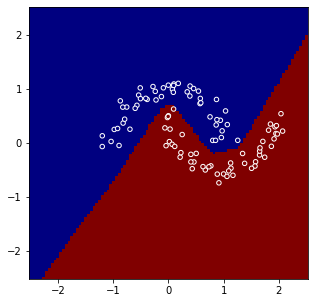

In [85]:
grid_activations = [model(x).data>0.5 for x in grid]
grid_activations = np.reshape(grid_activations, (100, 100))

plt.figure(figsize=(5, 5))
plt.pcolor(xx, yy, grid_activations, shading='auto', cmap='jet')
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet', edgecolor='w')


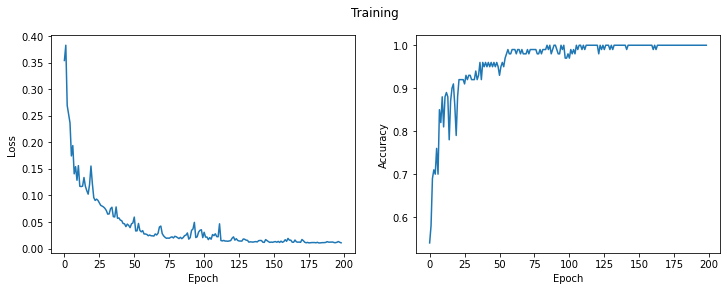

In [86]:
f = plt.figure(figsize=(12, 4)); #  

f.add_subplot(1,2,1);
plt.ylabel('Loss')
plt.plot(losses)
plt.xlabel('Epoch');

f.add_subplot(1,2,2);
plt.ylabel('Accuracy')
plt.plot(accuracies)
plt.xlabel('Epoch');

plt.suptitle('Training');
